In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import LinearNDInterpolator
rng = np.random.default_rng() # random number generator

## Configuration and CSV file ingestion

In [11]:
masses = np.arange(8, 31) # Msun
mass_range = np.linspace(np.min(masses), np.max(masses), int(1e3))

coupling = -10

isotopes = [
    'c12', 
    'o16', 
    'ne20', 
    'na23',
]

# what we read from the CSV files
labels = list(({
    # 'model': 'slice',
    'm': 'mass (Msun)',
    # 'coupling': 'coupling',
    # 'age': 'age (years)',
    'til': 'time to core O depletion (years)',
    # 'dt': 'dt (years)',
    
    # 'm_enc': 'mass enclosed (Msun)',
    # 'dm': 'dm (g)',
    # 'r': 'r (Rsun)',
    # 'dr': 'dr (cm)',
    # 'T': 'T (K)',
    # 'T_core': 'core T (K)',
    # 'T_eff': 'effective T (K)',
    # 'log_T': 'log T',
    
    # 'eps_grav': 'eps_grav (ergs/g s)',
    # 'eps_nuc': 'eps_nuc (ergs/g s)', 
    # 'eps_non_nuc_neu': 'eps_neu (ergs/g s)',
    # 'eps_a': 'eps_a (ergs/g s)',
    
    # 'lum_gamma': 'lum_gamma (ergs/s)',
    # 'lum_neu': 'lum_neu (ergs/s)',
    # 'lum_a': 'lum_a (ergs/s)',
    
    'lum_gamma_surf': 'surface lum_gamma (ergs/s)',
    # 'lum_neu_surf': 'surface lum_neu (ergs/s)',
    'num_a_surf': 'surface num_a (/s)',
    
    # 'cum_e_gamma': 'cumulative e_gamma (ergs)',
    # 'cum_e_neu': 'cumulative e_neu (ergs)',
    # 'cum_e_a': 'cumulative e_a (ergs)',
}).values())

lumSun = 3.846e33 # ergs/s
cm_per_kpc = 3.086e21

In [12]:
datatable = dict()

for m in masses:
    try:
        key = f'm{m:04.1f}_g{coupling:+04.2f}_0'
        run = pd.read_csv(f'csv/{key}/index.csv')
        entry = run[labels].to_numpy()[:max_slices].T
        datatable[m] = entry
        print(key, end=',\t')
    except FileNotFoundError as e:
        print(e)

m08.0_g-10.00_0,	m09.0_g-10.00_0,	m10.0_g-10.00_0,	m11.0_g-10.00_0,	m12.0_g-10.00_0,	m13.0_g-10.00_0,	m14.0_g-10.00_0,	m15.0_g-10.00_0,	m16.0_g-10.00_0,	m17.0_g-10.00_0,	m18.0_g-10.00_0,	m19.0_g-10.00_0,	m20.0_g-10.00_0,	m21.0_g-10.00_0,	m22.0_g-10.00_0,	m23.0_g-10.00_0,	m24.0_g-10.00_0,	m25.0_g-10.00_0,	m26.0_g-10.00_0,	m27.0_g-10.00_0,	m28.0_g-10.00_0,	m29.0_g-10.00_0,	m30.0_g-10.00_0,	

## Probability distributions

In [13]:
s0 = 0.0686 # kpc, bulge radius from galaxy center
se = 8.5 # kpc, earth radius from galaxy center
alpha = 0.74 # Verberne & Vink
beta = -3.52 # Verbene & Vink
fs0 = lambda s: ((s + s0)/se)**alpha * np.exp(beta * (s/se))

z0 = 0.4 # kpc, disk scale height
fz0 = lambda z: np.exp(-np.abs(z)/z0)

def fr0(r):
    theta_range = np.linspace(0, 2*np.pi, 100)
    s_range = np.linspace(0, 1, 1000)
    R, S, Theta = np.meshgrid(r, s_range, theta_range)
    S *= R

    zz = np.nan_to_num(np.sqrt(R**2 - S**2), 0) + 1e-3
    ss = np.nan_to_num(np.sqrt(S**2 + se**2 - 2*se*S*np.cos(Theta)), 0) + 1e-3

    return np.sum(
        (2*R/zz) * fz0(zz) * fs0(ss) * S,
        axis=(0,2)
   )

norm = lambda x: x / np.sum(x)
fr = lambda r: norm(fr0(r))

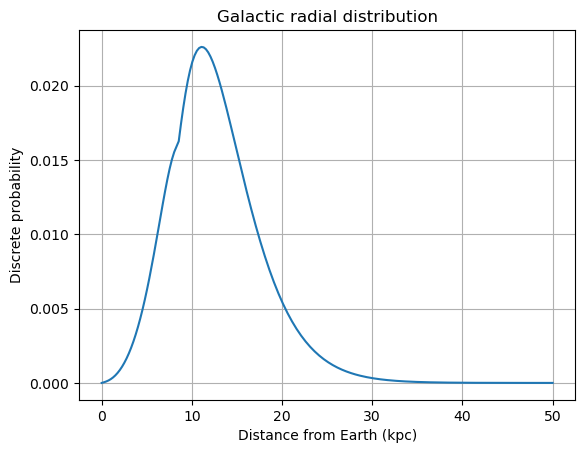

In [16]:
r_range = np.linspace(0, 50, 200)
plt.plot(r_range, fr(r_range))
plt.xlabel("Distance from Earth (kpc)")
plt.ylabel("Discrete probability")
plt.title("Galactic radial distribution")
plt.grid()

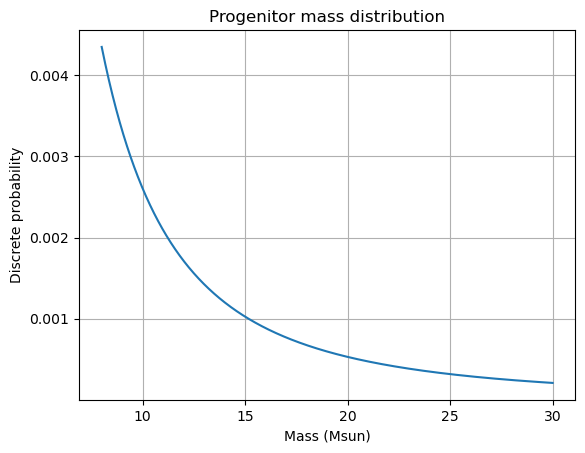

In [17]:
# inverse of initial mass function
imf0 = lambda m: m**(-2.3)
imf = lambda m: norm(imf0(m))
plt.plot(mass_range, imf(mass_range))
plt.grid()
plt.xlabel('Mass (Msun)')
plt.ylabel('Discrete probability')
plt.title("Progenitor mass distribution")
plt.show()

## Sampling

In [51]:
freq = 1/40 # SN per year
t_range = np.arange(0, 1e5, 1/freq) # years
r_range = np.linspace(0, 100, 100) + 1e-5 # kpc

r2 = (r_range*cm_per_kpc)**2 # cm2
falloff = np.sum(fr(r_range) / r2) # cm-2
print(f"Galactic falloff: {falloff:.3e} /cm2")

Galactic falloff: 4.031e-44 /cm2


In [41]:
# Total flux
lum_g_m = []
num_a_m = []
for m in masses:
    # integrate over time, weighted by SN frequency and luminosity data
    entry = datatable[m]
    t_raw, lum_g_t_raw, num_a_t_raw = entry[1:, ::-1]

    lum_g_t = np.interp(t_range, t_raw, lum_g_t_raw, left=0, right=0)
    num_a_t = np.interp(t_range, t_raw, num_a_t_raw, left=0, right=0)

    lum_g_m.append( np.sum(lum_g_t) )
    num_a_m.append( np.sum(num_a_t) )

# integrate over mass, weighted by Salpeter IMF
lum_g_m = np.array(lum_g_m) * imf(masses)
num_a_m = np.array(num_a_m) * imf(masses)

# integrate over distance, weighted by radial distribution and inverse-square
lum_g_r = np.sum(lum_g_m) * falloff
num_a_r = np.sum(num_a_m) * falloff

print(f"{lum_g:.3f} photon ergs/cm^2")
print(f"{num_a:.3f} axions/cm^2")

12.531 photon ergs/cm^2
19.006 axions/cm^2


In [59]:
# Sliced by mass or age
lum_g_m = []
num_a_m = []

_, imf_t = np.meshgrid(t_range, imf(masses))

for m in masses:
    # integrate over time, weighted by SN frequency and luminosity data
    entry = datatable[m]
    t_raw, lum_g_t_raw, num_a_t_raw = entry[1:, ::-1]

    lum_g_t = np.interp(t_range, t_raw, lum_g_t_raw, left=0, right=0)
    num_a_t = np.interp(t_range, t_raw, num_a_t_raw, left=0, right=0)

    lum_g_m.append(lum_g_t)
    num_a_m.append(num_a_t)

# integrate over mass, weighted by Salpeter IMF
lum_g_m = np.array(lum_g_m) * imf_t * falloff
num_a_m = np.array(num_a_m) * imf_t * falloff

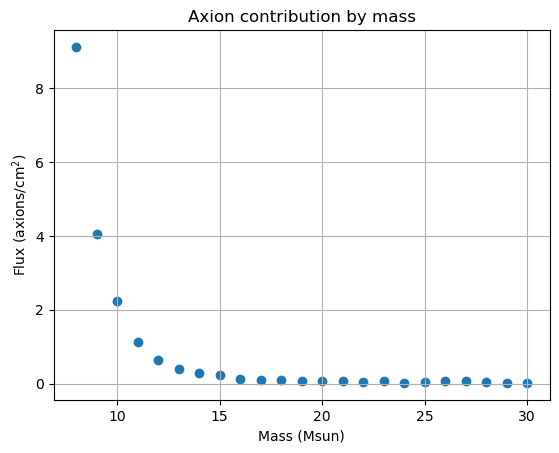

In [61]:
plt.scatter(masses, np.sum(num_a_m, axis=1))
plt.xlabel("Mass (Msun)")
plt.ylabel("Flux (axions/cm$^2$)")
plt.title("Axion contribution by mass")
plt.grid()

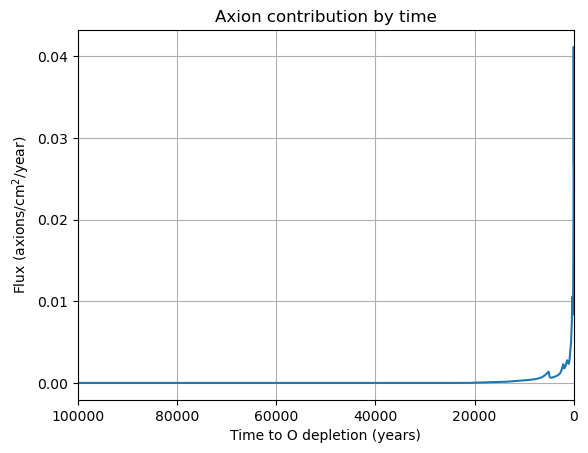

In [65]:
plt.plot(t_range, np.sum(num_a_m, axis=0) * freq)
plt.xlabel("Time to O depletion (years)")
plt.ylabel("Flux (axions/cm$^2$/year)")
plt.title("Axion contribution by time")
plt.xlim(1e5, 0)
plt.grid()